In [1]:
import os
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark


# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,152 kB]
Get:14 http://security.ubu

In [2]:
#Import dependencies
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from google.colab import drive
drive.mount('/content/drive')

# Import Keras Dependencies
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LeakyReLU, PReLU

Mounted at /content/drive


In [3]:
 # Import findspark and initialize.
import findspark
findspark.init()

In [4]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("weatherclassification").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [5]:
# Load in data
from pyspark import SparkFiles
url = 'https://weatherclassification.s3.amazonaws.com/weather_classification_data.csv'
spark.sparkContext.addFile(url)
print(SparkFiles.getRootDirectory())

spark_df = spark.read.csv(SparkFiles.get("weather_classification_data.csv"), sep=",", header=True, inferSchema=True)
spark_df.show()

/tmp/spark-a033fc61-a2f2-4543-90dc-e2c2f487b641/userFiles-379cc503-623d-4bdd-b1c0-d964f1d61264
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|  Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|         14|      73|       9.5|               82|partly cloudy|             1010.82|       2|Winter|            3.5|  inland|       Rainy|
|         39|      96|       8.5|               71|partly cloudy|             1011.43|       7|Spring|           10.0|  inland|      Cloudy|
|         30|      64|       7.0|               16|        clear|             1018.72|       5|Spring|            5.5|mountain|       Sunny|
|         38|      83|       1.5|               82|        

In [37]:
# Convert PySpark DataFrame to pandas DataFrame
weather_df = spark_df.toPandas()
weather_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [7]:
#Remove weather type
weather_data_no_type = weather_df.drop('Weather Type', axis=1)

In [8]:
# Convert categorical data to numeric with 'get_dummies'
weather_data_no_type = pd.get_dummies(weather_data_no_type).astype(int)
weather_data_no_type.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14,73,9,82,1010,2,3,0,0,0,1,0,0,0,1,0,1,0
1,39,96,8,71,1011,7,10,0,0,0,1,0,1,0,0,0,1,0
2,30,64,7,16,1018,5,5,1,0,0,0,0,1,0,0,0,0,1
3,38,83,1,82,1026,7,1,1,0,0,0,0,1,0,0,1,0,0
4,27,74,17,66,990,1,2,0,0,1,0,0,0,0,1,0,0,1


In [9]:
# Split our preprocessed data into our features and target arrays
X = weather_data_no_type
y = weather_df['Weather Type']

# Use LabelEncoder to convert categorical weather type labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = 4
y_one_hot = to_categorical(y_encoded, num_classes)

encoded_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)
label_mapping = dict(zip(encoded_labels, label_encoder.classes_))
print(f"Labels: {label_mapping}")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, random_state=1)

Labels: {0: 'Cloudy', 1: 'Rainy', 2: 'Snowy', 3: 'Sunny'}


In [10]:
# Normalize Data
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Create function for model creation
def gen_model(units, activation_functions, input_dim, optimizer):
  # Define the deep learning model
  nn_model = tf.keras.models.Sequential()
  nn_model.add(tf.keras.Input(shape=(input_dim,)))
  for i in range(len(units)):
    nn_model.add(tf.keras.layers.Dense(units=units[i], activation=activation_functions[i]))
  nn_model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return nn_model

In [32]:
# Final Model

def swish(x):
    return x * tf.sigmoid(x)

units = [64, 32, 16, 8]
activations_funcs = [swish, swish, swish, swish]
final_model = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = final_model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = final_model.evaluate(X_test,y_test,verbose=2)

print(f"Final Model Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6160 - loss: 1.0718 - val_accuracy: 0.8692 - val_loss: 0.4416
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8532 - loss: 0.4573 - val_accuracy: 0.8747 - val_loss: 0.3790
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8821 - loss: 0.3610 - val_accuracy: 0.8636 - val_loss: 0.3805
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8831 - loss: 0.3557 - val_accuracy: 0.8899 - val_loss: 0.3192
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8878 - loss: 0.3240 - val_accuracy: 0.8949 - val_loss: 0.3050
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8991 - loss: 0.2967 - val_accuracy: 0.8980 - val_loss: 0.2820
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9021 - loss: 0.2824 - val_accuracy: 0.8980 - val_loss: 0.2701
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8959 - loss: 0.2796 - val_accuracy: 0.

In [33]:
# Make predictions using testing data
predictions = final_model.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Final Model')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Final Model")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Final Model
[[763  54  17   8]
 [ 61 749  28   8]
 [ 30  12 767  11]
 [ 53  20  22 697]]
Classification Report Final Model
              precision    recall  f1-score   support

      Cloudy       0.84      0.91      0.87       842
       Rainy       0.90      0.89      0.89       846
       Snowy       0.92      0.94      0.93       820
       Sunny       0.96      0.88      0.92       792

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [34]:
# Get training and validation loss and accuracy values
final_model_losses = fit_model.history['loss']
final_model_accuracy = fit_model.history['accuracy']
final_model_val_losses = fit_model.history['val_loss']
final_model_val_accuracy = fit_model.history['val_accuracy']

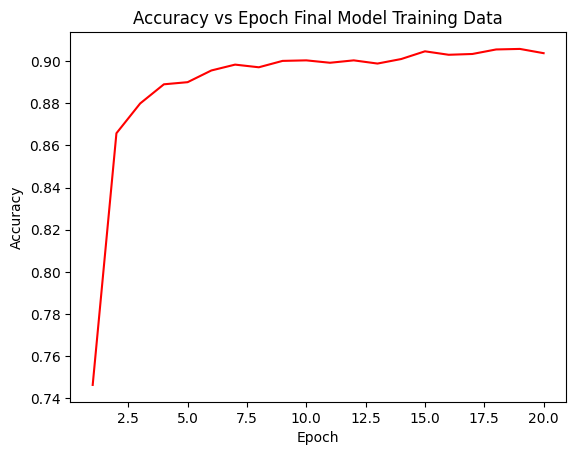

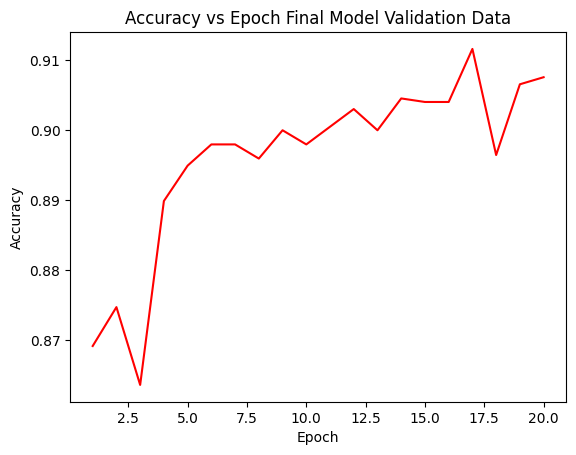

In [35]:
# Plot accuracy for final model training and validation data attempts

#final model training accuracy data
epochs = range(1, len(final_model_accuracy) + 1)

plt.plot(epochs, final_model_accuracy, 'r')

plt.title('Accuracy vs Epoch Final Model Training Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Final Model Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Final Model Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Final Model Training Data.png', format='png')

plt.show()



#final model validation accuracy data
epochs = range(1, len(final_model_accuracy) + 1)

plt.plot(epochs, final_model_val_accuracy, 'r')

plt.title('Accuracy vs Epoch Final Model Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Final Model Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Final Model Validation Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Final Model Validation Data.png', format='png')

plt.show()

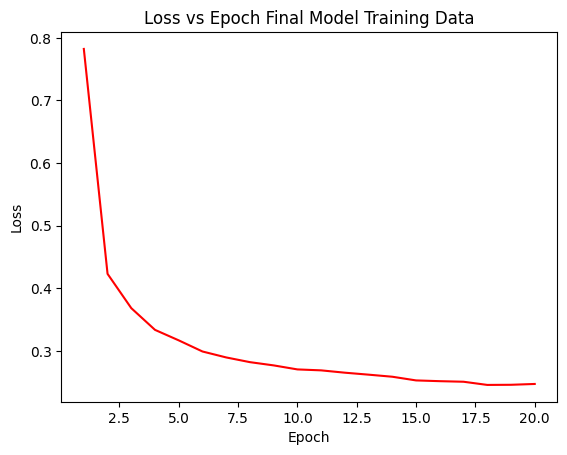

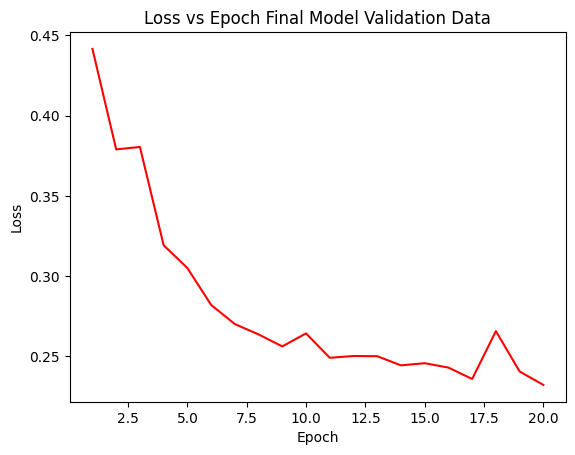

In [36]:
# Plot loss for final model training and validation data attempts

#final model training loss data
epochs = range(1, len(final_model_losses) + 1)

plt.plot(epochs, final_model_losses, 'r')

plt.title('Loss vs Epoch Final Model Training Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Final Model Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Final Model Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Final Model Training Data.png', format='png')

plt.show()



#final model validation loss data
epochs = range(1, len(final_model_losses) + 1)

plt.plot(epochs, final_model_val_losses, 'r')

plt.title('Loss vs Epoch Final Model Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Final Model Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Final Model Validation Data.png')


plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Final Model Validation Data.png', format='png')

plt.show()